<a href="https://colab.research.google.com/github/Turza006/fake-news-detections-ml-approach/blob/master/fake_news_0_0_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing the libraries

In [ ]:
import pandas as pd
from google.colab import drive

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sentence_transformers import SentenceTransformer
import numpy as np

import re

import matplotlib.pyplot as plt
import seaborn as sns


## Importing the dataset

In [ ]:
drive.mount('/content/drive')
real_news = pd.read_csv("/content/drive/MyDrive/news_data/LabeledAuthentic-7K.csv")
fake_news = pd.read_csv("/content/drive/MyDrive/news_data/LabeledFake-1K.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# prompt: print first 5 element from real news

print(fake_news.head())
print(real_news.head())


   articleID                    domain                        date  \
0          1         channeldhaka.news   2019-03-14T13:34:14+00:00   
1          2                 earki.com            সেম্বর ১৭, ২০১৮    
2          3                 earki.com  ২০:৩৯, জানুয়ারি ১৪, ২০১৯    
3          4         channeldhaka.news   2018-06-30T15:56:47+00:00   
4          5  motikontho.wordpress.com   2013-03-05T21:55:45+00:00   

        category    source   relation  \
0  International  Reporter  Unrelated   
1  Miscellaneous  Reporter  Unrelated   
2  Miscellaneous  Reporter  Unrelated   
3         Sports  Reporter  Unrelated   
4  Miscellaneous  Reporter  Unrelated   

                                            headline  \
0                           মুরগির হামলায় শেয়াল নিহত   
1            বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম   
2  বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...   
3                      অবসর নেয়ার ঘোষণা দিলেন মেসি !   
4  মাদারফাকার নহে, ব্রাদারফাকার: সাকা | দৈনিক মতি...

Data Preprocessing (crucial for Bangla text)

In [ ]:
def clean_text(text):
    """Basic text cleaning (customize as needed for Bangla)."""
    text = re.sub(r'\s+', ' ', text).strip()

    return text

# Clean and label the data

In [ ]:
fake_news['label'] = 1
fake_news['headline'] = fake_news['headline'].apply(clean_text)
fake_news['content'] = fake_news['content'].apply(clean_text)
fake_news['source'] = fake_news['source'].apply(clean_text)
fake_news['domain'] = fake_news['domain'].apply(clean_text)

real_news['label'] = 0
real_news['headline'] = real_news['headline'].apply(clean_text)
real_news['content'] = real_news['content'].apply(clean_text)
real_news['source'] = real_news['source'].apply(clean_text)
real_news['domain'] = real_news['domain'].apply(clean_text)

In [ ]:
print('process fake-----',fake_news.head())
print('process real-------',real_news.head())

process fake-----    articleID                    domain                        date  \
0          1         channeldhaka.news   2019-03-14T13:34:14+00:00   
1          2                 earki.com            সেম্বর ১৭, ২০১৮    
2          3                 earki.com  ২০:৩৯, জানুয়ারি ১৪, ২০১৯    
3          4         channeldhaka.news   2018-06-30T15:56:47+00:00   
4          5  motikontho.wordpress.com   2013-03-05T21:55:45+00:00   

        category    source   relation  \
0  International  Reporter  Unrelated   
1  Miscellaneous  Reporter  Unrelated   
2  Miscellaneous  Reporter  Unrelated   
3         Sports  Reporter  Unrelated   
4  Miscellaneous  Reporter  Unrelated   

                                            headline  \
0                           মুরগির হামলায় শেয়াল নিহত   
1            বিটিভিতে যেবার আমি ইন্টারভিউ দিতে গেলাম   
2  বিদেশ থেকে উন্নতমানের বিরোধীদল আমদানি করার পরা...   
3                      অবসর নেয়ার ঘোষণা দিলেন মেসি !   
4  মাদারফাকার নহে, ব্রাদারফাকার: স

# Combine datasets

In [ ]:
combined_data = pd.concat([fake_news, real_news], ignore_index=True)

# Feature Engineering: Combine headline and article, then vectorize.

In [ ]:
combined_data['combined_text'] = combined_data['headline'] + ' ' + combined_data['content'] +  ' ' + combined_data['domain']

# TF-IDF Vectorization


In [ ]:
vectorizer = TfidfVectorizer(max_features=8000)
X = vectorizer.fit_transform(combined_data['combined_text'])
y = combined_data['label']

feature_names = vectorizer.get_feature_names_out()

# Split data into training and testing sets

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train and Evaluate Naive Bayes

In [ ]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train, y_train)
nb_predictions = nb_classifier.predict(X_test)
print("Naive Bayes:")
print(classification_report(y_test, nb_predictions))
print("Accuracy:", accuracy_score(y_test, nb_predictions))

Naive Bayes:
              precision    recall  f1-score   support

           0       0.87      1.00      0.93      1427
           1       0.97      0.23      0.37       274

    accuracy                           0.87      1701
   macro avg       0.92      0.61      0.65      1701
weighted avg       0.89      0.87      0.84      1701

Accuracy: 0.8741916519694297


#Naive Bayes feature importance

In [ ]:
nb_feature_log_prob = nb_classifier.feature_log_prob_[1] - nb_classifier.feature_log_prob_[0]
nb_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': nb_feature_log_prob
}).sort_values(by='Importance', ascending=False)

print("Top 20 features indicating fake news (Naive Bayes):")
print(nb_feature_importance.head(10))

print("\nTop 20 features indicating real news (Naive Bayes):")
print(nb_feature_importance.tail(10))

Top 20 features indicating fake news (Naive Bayes):
          Feature  Importance
374          news    4.467309
134  channeldhaka    4.431240
193         earki    3.887030
98    bengalbeats    3.695196
97         bengal    3.671213
92          beats    3.671213
580     wordpress    3.588236
358    motikontho    3.588236
209          eআরক    3.446745
30    adsbygoogle    3.253868

Top 20 features indicating real news (Naive Bayes):
            Feature  Importance
1534            উইক   -2.194095
6263            সদর   -2.211436
70           bangla   -2.211840
77    banglatribune   -2.342766
6454            সড়ক   -2.375286
301      jagonews24   -2.401797
5168            মরদ   -2.409307
1636            উপজ   -2.444505
280   independent24   -2.603785
1042            আফগ   -2.682156


#Visualize the top 10 important features for Naive Bayes

> Add blockquote



/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2438 (\N{BENGALI LETTER AA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2480 (\N{BENGALI LETTER RA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2453 (\N{BENGALI LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


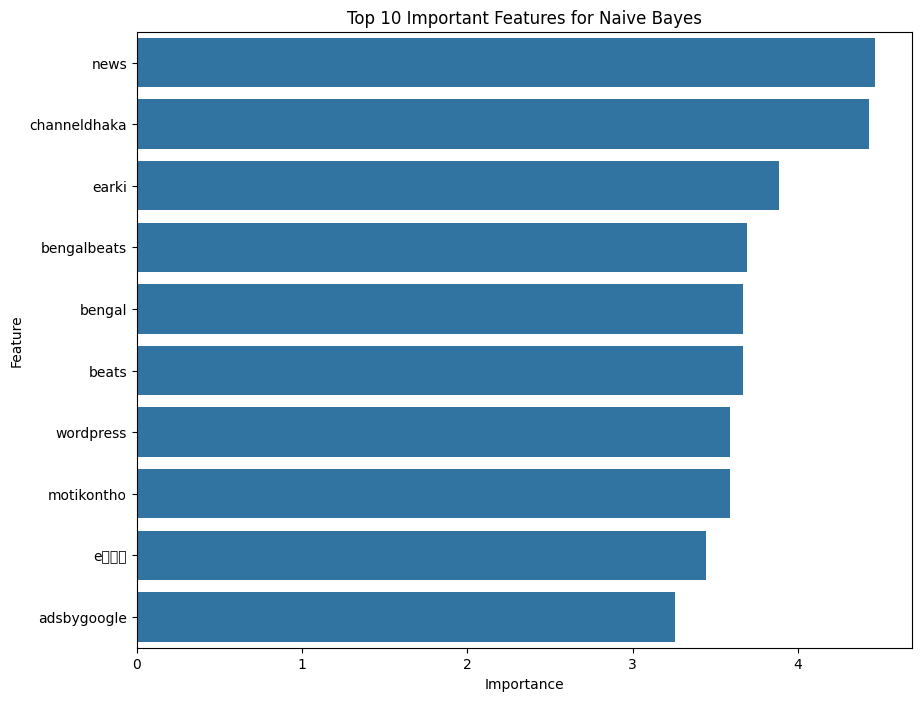

In [ ]:
top_nb_features = nb_feature_importance.head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_nb_features)
plt.title('Top 10 Important Features for Naive Bayes')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Generate classification report for Naive Bayes

In [ ]:
nb_report = classification_report(y_test, nb_predictions, output_dict=True)
nb_df = pd.DataFrame(nb_report).transpose()

# Train and Evaluate Random Forest

In [ ]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42) # Adjust n_estimators as needed
rf_classifier.fit(X_train, y_train)
rf_predictions = rf_classifier.predict(X_test)
print("\nRandom Forest:")
print(classification_report(y_test, rf_predictions))
print("Accuracy:", accuracy_score(y_test, rf_predictions))


Random Forest:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98      1427
           1       1.00      0.82      0.90       274

    accuracy                           0.97      1701
   macro avg       0.98      0.91      0.94      1701
weighted avg       0.97      0.97      0.97      1701

Accuracy: 0.9711934156378601


# Random Forest feature importance


In [ ]:
rf_feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': rf_classifier.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("\nTop 20 important features indicating fake news (Random Forest):")
print(rf_feature_importance.head(20))

print("\nTop 20 important features indicating real news (Random Forest):")
print(rf_feature_importance.tail(20))


Top 20 important features indicating fake news (Random Forest):
               Feature  Importance
134       channeldhaka    0.046843
374               news    0.044892
193              earki    0.033801
97              bengal    0.020870
143                com    0.020830
358         motikontho    0.018642
92               beats    0.016160
98         bengalbeats    0.015190
6545                হয    0.012395
580          wordpress    0.012330
1069                আম    0.010162
209               eআরক    0.009237
1033               আপন    0.008703
4797                বর    0.008239
2293                ওয    0.008022
100   bengaliviralnews    0.007258
2405                কণ    0.006457
2658               গঘন    0.006199
1093                আর    0.004921
6593                হয়    0.004907

Top 20 important features indicating real news (Random Forest):
               Feature  Importance
3918                দঙ         0.0
3943               দনশ         0.0
3934               দনগ        

# Visualize the top 10 important features for Random Forest

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2489 (\N{BENGALI LETTER HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Bengali natively.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 2479 (\N{BENGALI LETTER YA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


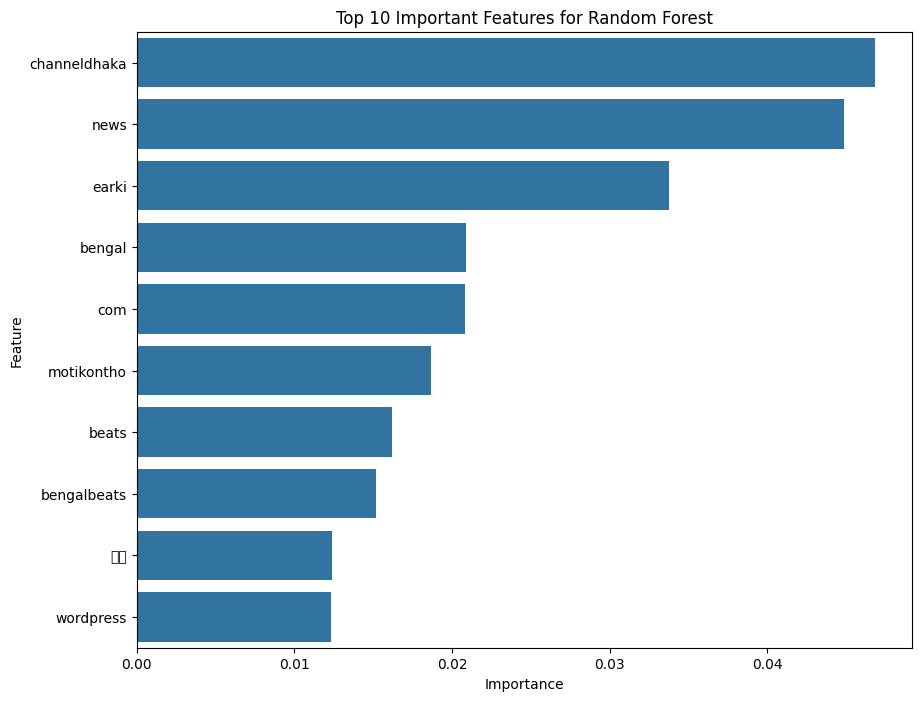

In [ ]:
top_rf_features = rf_feature_importance.head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_rf_features)
plt.title('Top 10 Important Features for Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

# Generate classification report for Random Forest

In [ ]:
rf_report = classification_report(y_test, rf_predictions, output_dict=True)
rf_df = pd.DataFrame(rf_report).transpose()

# Plot the metrics

<ipython-input-44-096c6d63014c>:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
<ipython-input-44-096c6d63014c>:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)


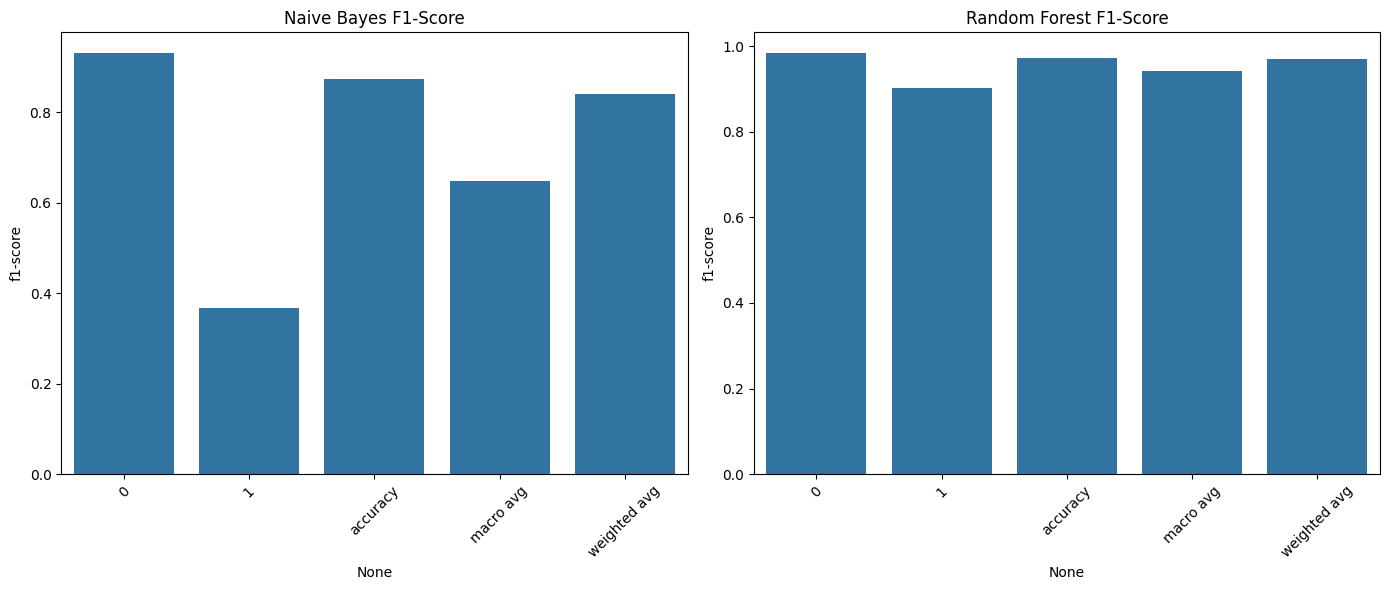

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.barplot(x=nb_df.index, y='f1-score', data=nb_df, ax=axes[0])
axes[0].set_title('Naive Bayes F1-Score')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)

sns.barplot(x=rf_df.index, y='f1-score', data=rf_df, ax=axes[1])
axes[1].set_title('Random Forest F1-Score')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)

plt.tight_layout()
plt.show()

# Example Prediction (Remember to preprocess the input text)


#fake news

In [ ]:
new_headline = "ড. ইউনূসের এডিটেড ভিডিও দিয়ে জুয়ার অ্যাপের প্রচারণা"
new_article = "সামাজিক যোগাযোগ মাধ্যম ফেসবুকে একটি ভিডিও পোস্ট করা হয়েছে। ভিডিওতে দেখা যাচ্ছে অন্তর্বর্তীকালীন সরকারের প্রধান উপদেষ্টা ও নোবেল বিজয়ী ড. মুহাম্মদ ইউনূস বলেছেন, একটি অ্যাপ তৈরি করা হয়েছে যা বেকারত্ব দূর করতে সাহায্য করবে। একই ভিডিওতে ডাক, টেলিযোগাযোগ ও তথ্যপ্রযুক্তি উপদেষ্টা মো. নাহিদ ইসলামকে বলতে দেখা যায়, সব শিক্ষার্থীরা মুহাম্মদ ইউনূসের অ্যাপটিতে খেলে আয় করছে। ভিডিওটিতে সময় টেলিভিশনের লোগোযুক্ত একজন সংবাদ পাঠিকার এ সংক্রান্ত সংবাদ পাঠের দৃশ্যও যুক্ত করা হয়েছে। ভিডিও সহ এরকম একটি পোস্ট দেখুন এখানে। এছাড়াও আরো একটি ভিডিওতে ড. মুহাম্মদ ইউনূসকে বলতে দেখা যায়, দেশের বর্তমান বিপর্যয়ের কারণে আমি একটি নতুন এপ্লিকেশন তৈরি করার সিদ্ধান্ত নিয়েছি। Crazy Time নামক এই অ্যাপে মাত্র ৫ টাকা বিনিয়োগ করে অনেক ভালো আয় করা যাবে। এমনকি প্রথম দিনেই ৫০ হাজার বা এক লক্ষ টাকা জিততে (আয় করতে) পারেন। ভিডিও সহ এরকম একটি পোস্ট দেখুন এখানে। গত ২০ অক্টোবর 'Yudi liceth Arboleda' নামের পেজ থেকে ভিডিওটি (প্রথমে উল্লিখিত) পোস্ট করা হয়। ভিডিওটি দিয়ে একটি অ্যাপের প্রচারণা চালানো হচ্ছে। পোস্টটির স্ক্রিনশটের (কোলাজ) দেখুন--"
new_domain = "earki.co"

new_text = clean_text(new_headline + ' ' + new_article+ ' '+ new_domain)
new_text_vec = vectorizer.transform([new_text])

In [ ]:
nb_prob = nb_classifier.predict_proba(new_text_vec)[0][1]
rf_prob = rf_classifier.predict_proba(new_text_vec)[0][1]

print(f"\nNaive Bayes probability of being fake: {nb_prob:.2f}")
print(f"Random Forest probability of being fake: {rf_prob:.2f}")


Naive Bayes probability of being fake: 0.09
Random Forest probability of being fake: 0.49


In [ ]:
# Extract features from the new text
new_text_feature_indices = new_text_vec.nonzero()[1]
new_text_feature_names = [feature_names[i] for i in new_text_feature_indices]

# Print important features for Naive Bayes
print("\nImportant features in the news (Naive Bayes):")
nb_important_features = nb_feature_importance[nb_feature_importance['Feature'].isin(new_text_feature_names)].sort_values(by='Importance', ascending=False)
print(nb_important_features.head(10))

# Print important features for Random Forest
print("\nImportant features in the news (Random Forest):")
rf_important_features = rf_feature_importance[rf_feature_importance['Feature'].isin(new_text_feature_names)].sort_values(by='Importance', ascending=False)
print(rf_important_features.head(10))


Important features in the news (Naive Bayes):
     Feature  Importance
193    earki    3.887030
2098    এরকম    1.615479
4299     নশট    1.466162
139       co    1.264778
534     time    1.233823
2264      ওট    1.074268
2270      ওত    0.705949
4836     বলত    0.666348
1069      আম    0.598613
2082    এমনক    0.569125

Important features in the news (Random Forest):
     Feature  Importance
193    earki    0.033801
1069      আম    0.010162
4797      বর    0.008239
1093      আর    0.004921
6593      হয়    0.004907
6314      সব    0.004425
1769      এই    0.003863
2098    এরকম    0.002733
1840      এক    0.002720
1865     একট    0.002701
